In [1]:
!pip install lightgbm xgboost --quiet

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import lightgbm as lgb
import xgboost as xgb

# Set plot style
sns.set(style='whitegrid')


In [2]:
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')

# Show first 5 rows of training data
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Missing values in training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


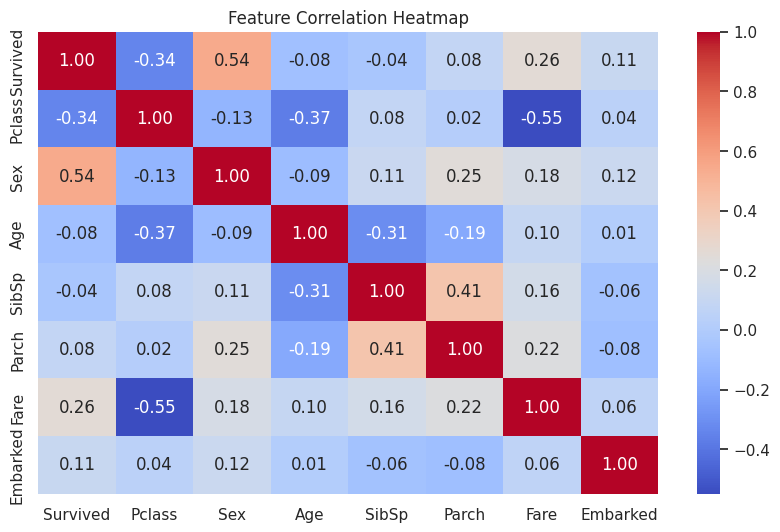

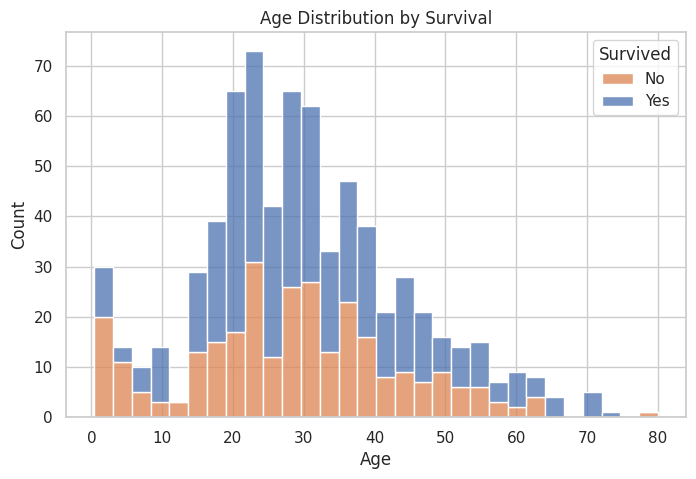

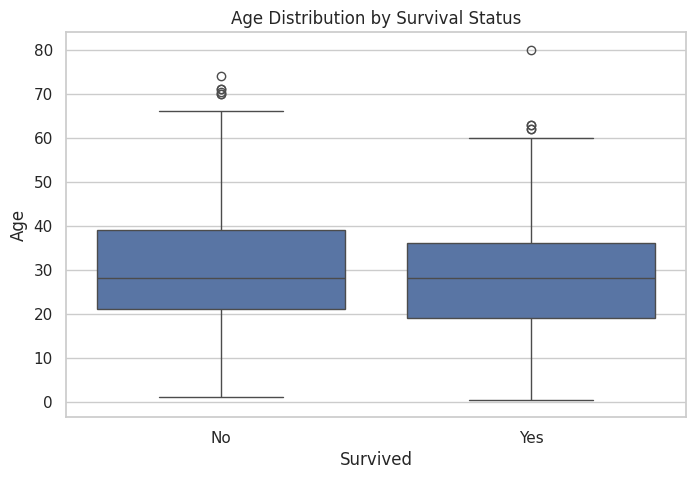

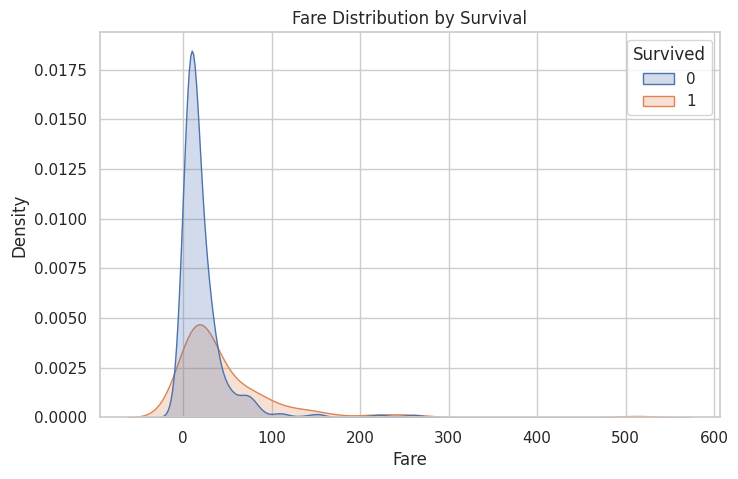

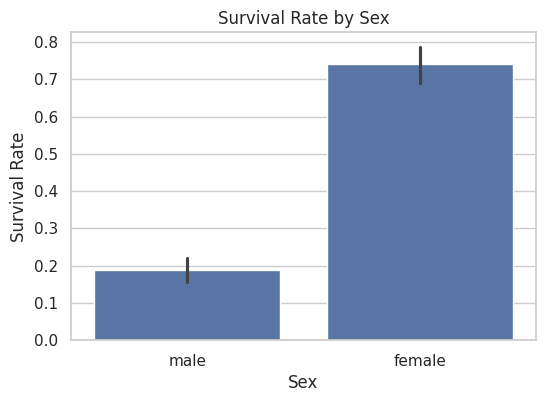

In [5]:
# Check missing values
print("Missing values in training data:\n", train_data.isnull().sum())

# Drop columns with non-numeric data before correlation analysis
corr_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Drop irrelevant columns
corr_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Convert categorical columns to numeric using label encoding
corr_data['Sex'] = corr_data['Sex'].map({'male': 0, 'female': 1})
corr_data['Embarked'] = corr_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Now plot the correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


# Age distribution by survival
plt.figure(figsize=(8,5))
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

# Boxplot Age vs Survived
plt.figure(figsize=(8,5))
sns.boxplot(x='Survived', y='Age', data=train_data)
plt.title("Age Distribution by Survival Status")
plt.xlabel("Survived")
plt.ylabel("Age")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Fare distribution KDE by survival
plt.figure(figsize=(8,5))
sns.kdeplot(data=train_data, x='Fare', hue='Survived', fill=True)
plt.title("Fare Distribution by Survival")
plt.xlabel("Fare")
plt.show()

# Bar plot Survival by Sex
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.show()


In [6]:
# Impute missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

# Drop irrelevant columns
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Encode categorical variables
le = LabelEncoder()

train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])

train_data['Embarked'] = le.fit_transform(train_data['Embarked'])
test_data['Embarked'] = le.transform(test_data['Embarked'])


<ipython-input-6-404fd0ac8253>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
<ipython-input-6-404fd0ac8253>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [7]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 712 samples
Testing set size: 179 samples


In [8]:
lgbm_model = lgb.LGBMClassifier(objective='binary', metric='accuracy', boosting_type='gbdt', random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

print("\n🔹 LightGBM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("F1-score:", f1_score(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [9]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n🔹 XGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



🔹 XGBoost Model Performance:
Accuracy: 0.8156424581005587
Precision: 0.7647058823529411
Recall: 0.7536231884057971
F1-score: 0.7591240875912408

Confusion Matrix:
 [[94 16]
 [17 52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

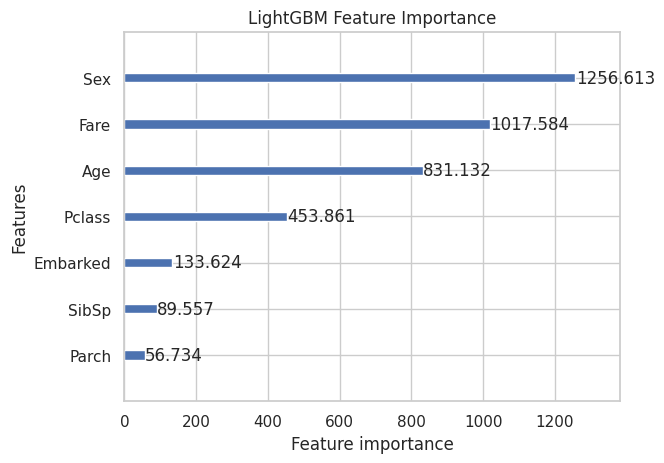

<Figure size 1000x600 with 0 Axes>

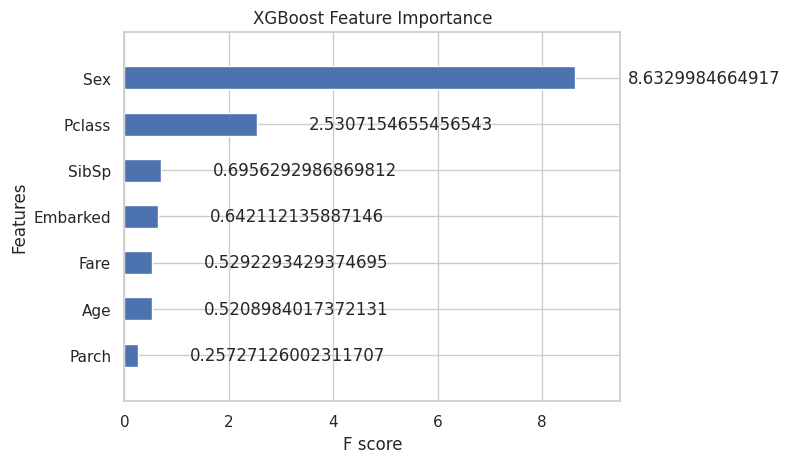

In [10]:
# LightGBM Feature Importance
plt.figure(figsize=(10,6))
lgb.plot_importance(lgbm_model, max_num_features=10, importance_type='gain', title="LightGBM Feature Importance")
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.5, title="XGBoost Feature Importance")
plt.show()



🔹 Model Comparison:
      Model  Accuracy  Precision    Recall  F1-score
0  LightGBM  0.798883   0.761905  0.695652  0.727273
1   XGBoost  0.815642   0.764706  0.753623  0.759124


<ipython-input-11-fb874c2e76ca>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='Set2')


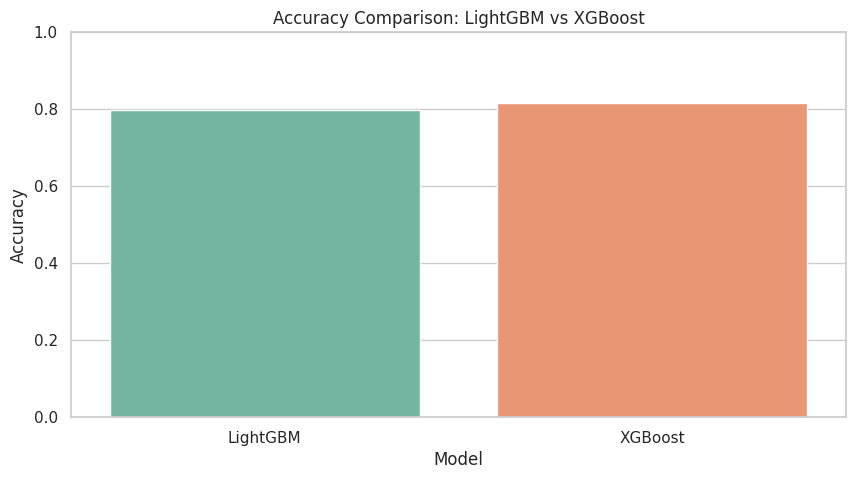

In [11]:
models = ['LightGBM', 'XGBoost']
accuracy_scores = [accuracy_score(y_test, y_pred_lgbm), accuracy_score(y_test, y_pred_xgb)]
precision_scores = [precision_score(y_test, y_pred_lgbm), precision_score(y_test, y_pred_xgb)]
recall_scores = [recall_score(y_test, y_pred_lgbm), recall_score(y_test, y_pred_xgb)]
f1_scores = [f1_score(y_test, y_pred_lgbm), f1_score(y_test, y_pred_xgb)]

metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

print("\n🔹 Model Comparison:")
print(metrics_df)

# Plotting Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='Set2')
plt.title("Accuracy Comparison: LightGBM vs XGBoost")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
